In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set()

yvr = pd.read_csv('yvr4analyze_both.csv',index_col =0, parse_dates = [1])
yvrCases = pd.read_csv('Covid-Data/yvr-modified.csv', index_col =0, parse_dates = [6])
# yvr, yvrCases
#%store -r
yvr

,Date,AirportName,PercentOfBaseline,City,State,Country,lat,long,timestamp,Prediction,Month
0,2020-03-16,Vancouver International,100,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584317e+09,72.573313,March
1,2020-03-17,Vancouver International,93,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584403e+09,72.604748,March
2,2020-03-18,Vancouver International,97,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584490e+09,72.636182,March
3,2020-03-19,Vancouver International,92,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584576e+09,72.667617,March
4,2020-03-20,Vancouver International,94,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584662e+09,72.699051,March
5,2020-03-21,Vancouver International,85,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584749e+09,72.730486,March
6,2020-03-22,Vancouver International,89,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584835e+09,72.761920,March
7,2020-03-23,Vancouver International,97,Richmond,British Columbia,Canada,49.193579,-123.177541,1.584922e+09,72.793355,March
8,2020-03-24,Vancouver International,82,Richmond,British Columbia,Canada,49.193579,-123.177541,1.585008e+09,72.824790,March
9,2020-03-25,Vancouver International,81,Richmond,British Columbia,Canada,49.193579,-123.177541,1.585094e+09,72.856224,March


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


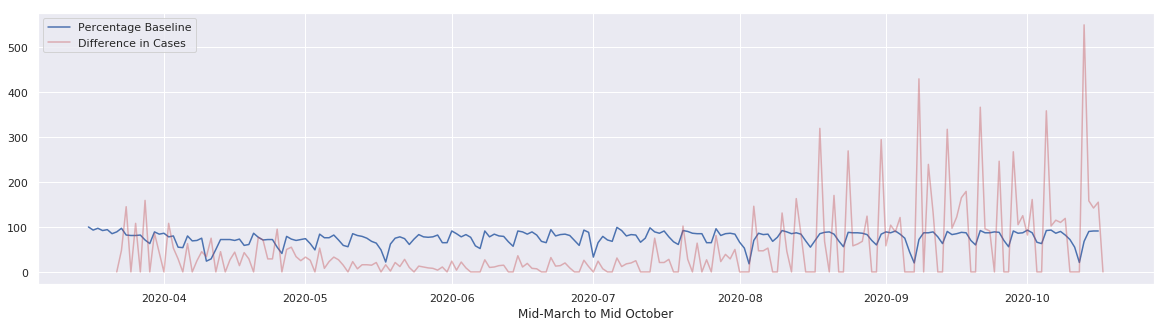

In [2]:
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yvrCases["Date"], yvrCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()


Date                 208
Difference           208
Confirmed            208
Diff_smooth          208
PercentOfBaseline    208
Baseline_smooth      208
dtype: int64


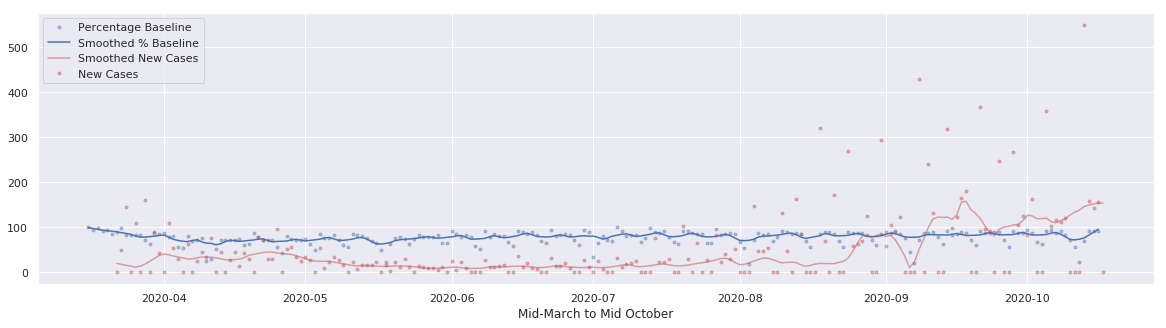

In [14]:
# We see that new cases per day is 0 sometimes, which isn't actually true, just that maybe
# the cases found for a couple of days aren't logged that day, but instead logged on another day, so we should
# smooth the new cases over a couple of days
# We also want to smooth out the weekly cycles in the data to see the long-run correlations
from statsmodels.nonparametric.smoothers_lowess import lowess
new_cases_smooth = lowess(yvrCases['Difference'], yvrCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yvr['PercentOfBaseline'], yvr["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yvrCases['Diff_smooth'] = new_cases_smooth[:,1]
yvr['Baseline_smooth'] = baseline_smooth[:,1]
# This is to make sure both yvr and yvrCases start and end on the same dates
if (yvr.count().loc['Date'] != yvrCases.count().loc['Date']):
    joined = yvrCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yvrCases["Diff_smooth"]
    y = yvr["Baseline_smooth"]
joined=joined.dropna()
print(joined.count())
#can use X,y or original, doesn't really matter
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yvr["Date"], yvr['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yvrCases["Date"], yvrCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

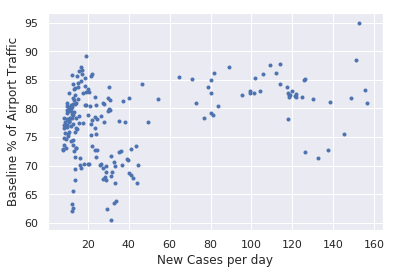

In [15]:
# Is there statistical correlation between the two values- Baseline, and New Cases?
# We use smoothed versions of data because don't want to analyze the weekly noise (tho holidays still exist)
# y = Diff
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
model = LinearRegression(fit_intercept = True)
model.fit(np.array(X).reshape(-1,1), np.array(y).reshape(-1,1))
#linearX = np.linspace(0,160)
#plt.plot(linearX, model.predict(linearX.reshape(-1,1)), 'r-', label = "Trend")

In [ ]:
# What about confirmed?
#smooth it, and then plot it
aaaaaa

In [ ]:
# Analyzing statistical correlation in --> first wave

In [ ]:
# ML with new cases, total cases, global cases: total + new, vs y= Baseline

In [ ]:
temp = yvr.shift(-1)
temp["PercentOfBaseline"] = temp["PercentOfBaseline"]

X = np.array(yvr['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)

In [ ]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
plt.plot(X, model.predict(X), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()